<a href="https://colab.research.google.com/github/SopTax/Cancer-type-prediction-with-GNN/blob/main/Cancer_Label_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Lab3: Graph Neural Networks
### ***Implement a GNN to classify breast cancer patients in LUMINAL A / LUMINAL B***

1. Each network node corresponds to a patient
2. Node feature vector is the entire gene expression profile of the patient
3. Node label is the patient class (*Luminal A / Luminal B*)
4. Edges are not provided. You must compute them using pearson correlation coefficient.
E.g.: x_ij=corr(reat_vec_node_i,feat_vec_node_j)
5. Aim: *predict patient node labels using a GNN*
6. Are the performances better or worse compared to an MLP classifier?


## 1. Load, inspect and process data

***Necessary Imports***

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder,scale,MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report,matthews_corrcoef
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch_geometric.utils import to_undirected,to_networkx
from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F
from torch.optim import Adam
import networkx as nx


from IPython.display import display, Javascript





!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:

PATH='/content/drive/MyDrive/AI_Bioinformatics/Lab3/dataset_LUMINAL_A_B.csv'
df = pd.read_csv(PATH)
df.head()


,l,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,...,ENSG00000088356.5,ENSG00000176752.6,ENSG00000223082.1,ENSG00000237714.1,ENSG00000200959.1,ENSG00000270971.2,ENSG00000267313.5,ENSG00000151632.15,ENSG00000269107.1,ENSG00000268889.1
0,Luminal A,2356.253792,26808.891103,57790.161586,0.0,71389.111749,381288.489078,0.0,1677.413295,1.969141e+06,...,113036.499486,0.0,20911.752405,13957.784680,1.047700e+06,0.0,1937.768563,10731.974977,0.0,0.0
1,Luminal A,0.000000,231.960840,115769.964478,0.0,77938.573803,238017.846096,0.0,0.000000,4.865670e+06,...,850405.301444,0.0,0.000000,2122.068451,0.000000e+00,0.0,5499.352680,2479.070667,0.0,0.0
2,Luminal A,0.000000,315.873536,44954.933833,0.0,58546.997851,249302.406604,0.0,270.107768,2.519212e+06,...,301948.579552,0.0,0.000000,481.622432,0.000000e+00,0.0,312.031830,4822.690978,0.0,0.0
3,Luminal A,1074.333108,0.000000,86991.783442,0.0,36082.381881,176274.146728,0.0,101.975469,2.855010e+06,...,293581.147891,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,12631.387770,0.0,0.0
4,Luminal A,1395.887715,0.000000,65199.337535,0.0,91469.201926,263704.398926,0.0,66.248682,4.235429e+06,...,350449.557585,0.0,0.000000,1181.263740,0.000000e+00,0.0,0.000000,1626.418477,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 1023 entries, l to ENSG00000268889.1
dtypes: float64(938), int64(84), object(1)
memory usage: 799.3+ KB


In [ ]:
df.describe()

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000088356.5,ENSG00000176752.6,ENSG00000223082.1,ENSG00000237714.1,ENSG00000200959.1,ENSG00000270971.2,ENSG00000267313.5,ENSG00000151632.15,ENSG00000269107.1,ENSG00000268889.1
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,1.000000e+02,100.000000,...,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000
mean,505.617509,494.717258,77608.314158,57.539468,76981.681022,239320.042842,91.50984,1157.833612,3.919381e+06,4834.859023,...,3.677872e+05,7.167876,1976.319473,1167.714066,1.646436e+05,15.068282,1078.113970,22079.485447,22.054727,663.582024
std,969.577192,2890.536569,46142.669132,575.394685,25543.954127,81397.596469,609.07346,3435.353070,1.964040e+06,10886.257666,...,2.272400e+05,71.678756,12824.496704,2206.373727,1.044512e+06,133.659953,7921.240310,71226.135608,109.508598,1011.235265
min,0.000000,0.000000,19979.019446,0.000000,29152.656417,77032.880341,0.00000,0.000000,5.420742e+05,0.000000,...,1.130365e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,85.347215,0.000000,0.000000
25%,0.000000,0.000000,48734.896439,0.000000,59362.529641,182370.882767,0.00000,126.060960,2.713867e+06,1340.064205,...,2.248784e+05,0.000000,0.000000,195.820665,0.000000e+00,0.000000,0.000000,2457.646307,0.000000,0.000000
50%,0.000000,0.000000,64797.711166,0.000000,75532.983961,221961.182134,0.00000,276.317740,3.418804e+06,2521.486771,...,2.989436e+05,0.000000,0.000000,542.626456,1.514835e+03,0.000000,0.000000,6748.497152,0.000000,0.000000
75%,650.363286,112.283286,91199.819499,0.000000,94474.565392,279025.021452,0.00000,618.518582,4.424999e+06,4513.841823,...,4.490865e+05,0.000000,0.000000,1184.518725,4.858684e+03,0.000000,176.765777,13720.372174,0.000000,1072.544951
max,7086.544424,26808.891103,277388.135076,5753.946848,147768.290814,567420.311037,5816.85346,25994.841831,1.093374e+07,86793.265494,...,1.425334e+06,716.787559,125786.163522,13957.784680,8.236287e+06,1326.158814,79001.298076,670121.423149,651.579347,5986.547799


<Axes: xlabel='count', ylabel='l'>

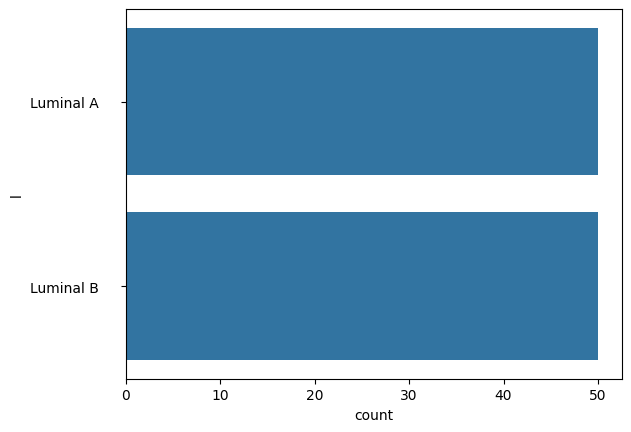

In [ ]:
import seaborn as sns
sns.countplot(df['l'])

*Support Functions*

In [ ]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

In [ ]:
def plot_loss(loss_values, title='Training Loss Over Epochs'):
    """Plot the training loss over epochs."""
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

### **Processing**
- Encoding target in binary variable.
- Scale features: scale to [0,1] using MinMaxScaler
- Compute pearson correlation coeff. (which will be the edges of our graph)
- Build the graph representation of our dataset

***Encoding and scaling***

***Some considerations on scaling:***
*scale* standardizes the features by removing the mean and scaling to unit variance.
We want to preserve distribution of the data, so better for this scenario might be *MinMaxScaling*.
However, even if *MinMaxScaling* preservs distribution, the correlation value is not only affected by the distribution but also by the scale itself. While the distribution is preserved, the scale of the features is compressed or expanded to fit within the range [0, 1]. This compression or expansion can affect the correlation coefficient because it changes the spread and variability of the data.
Furthermore, the features at hand have significantly different ranges so it's crucial to scale ***before*** computing correlations.

In [ ]:

encoder = OrdinalEncoder()

y= encoder.fit_transform(df[['l']])
features=df.drop(labels=['l'], axis=1)
scaler = MinMaxScaler()
X=scaler.fit_transform(features)
#X=scaler(features.values)

***Correlation Matrix***

In [ ]:
#I need to make a graph out of this. Each person is a node, with the whole gene expression as features.
#Edges need to be computed.
#l is the node label

#First: Correlation matrix

corr = np.corrcoef(X)

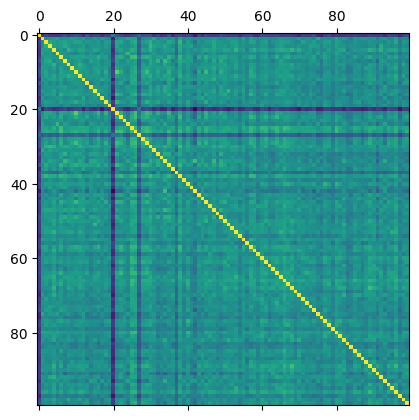

In [ ]:

plt.matshow(corr)

Get tensors

In [ ]:
X=torch.tensor(X, dtype=torch.float32)
y=torch.tensor(y, dtype=torch.long)

***Building the graph representation***

In [ ]:
#threshold = 0.3  # Include all edges with Pearson correlation > 0.00
threshold=np.average(corr)

edge_index = []
for i in range(len(corr)):
    for j in range(len(corr)):
            if i!=j:
              if abs(corr[i,j])>threshold:
                edge_index.append([i, j])

edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

data = Data(x=X, edge_index=edge_index_tensor, y=y)

In [ ]:
edge_index_tensor

tensor([[ 1,  1,  1,  ..., 99, 99, 99],
        [ 2,  3,  4,  ..., 91, 92, 96]])

In [ ]:
transform = T.Compose([
    T.RemoveIsolatedNodes(),
    T.RandomNodeSplit(num_train_per_class=80, num_val=0, num_test=20)
])
data = transform(data)
if data.y.dim() > 1:
    # If y is of shape (n_samples, 1), we need to reshape it to (n_samples,)
    data.y = data.y.squeeze()

In [ ]:
print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[97, 1022], edge_index=[2, 5510], y=[97], train_mask=[97], val_mask=[97], test_mask=[97])
Number of nodes: 97
Number of edges: 5510
Average node degree: 56.80
Number of training nodes: 77
Training node label rate: 0.79
Has isolated nodes: False
Has self-loops: False
Is undirected: True


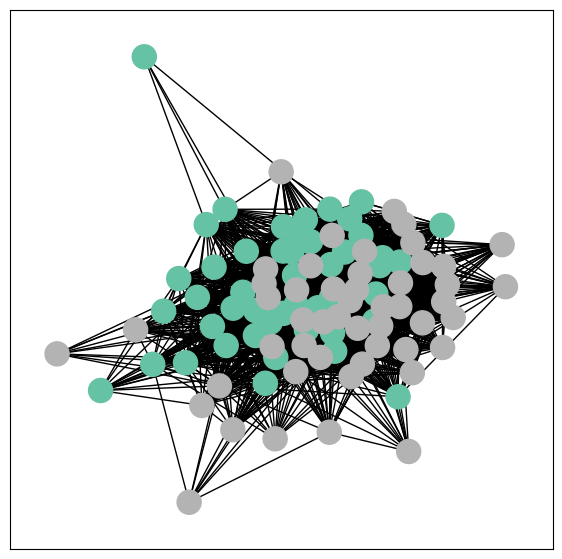

In [ ]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

### First, let's try and train a MLP

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self,in_dim,hidden_ch,classes):
    super().__init__()
    torch.manual_seed(12345)
    self.lin1=Linear(in_dim,hidden_ch)
    self.lin2=Linear(hidden_ch,classes)

  def forward(self,x):
    x=self.lin1(x)
    x=x.relu()
    x=F.dropout(x,p=0.5,training=self.training)
    x = self.lin2(x)
    return x

model=MLP(in_dim=1022,hidden_ch=16,classes=2)
print(model)

MLP(
  (lin1): Linear(in_features=1022, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
def train_MLP(model, optimizer, data, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test_MLP(model, data, criterion):
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    test_loss = criterion(out[data.test_mask], data.y[data.test_mask])
    test_pred = pred[data.test_mask]
    test_true = data.y[data.test_mask]
    test_correct = test_pred == test_true
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    conf_mat = confusion_matrix(test_true.cpu().numpy(), test_pred.cpu().numpy())
    return test_loss.item(), test_acc,test_pred,conf_mat


Training with lr=0.01, weight_decay=0.0005
Epoch: 010, lr=0.01, wd=0.0005, Training Loss: 0.3388, Test Loss: 0.4246, Test Acc: 0.9500
Epoch: 020, lr=0.01, wd=0.0005, Training Loss: 0.1335, Test Loss: 0.2905, Test Acc: 0.8500
Epoch: 030, lr=0.01, wd=0.0005, Training Loss: 0.1081, Test Loss: 0.2631, Test Acc: 0.8500
Epoch: 040, lr=0.01, wd=0.0005, Training Loss: 0.0470, Test Loss: 0.1910, Test Acc: 0.9000
Epoch: 050, lr=0.01, wd=0.0005, Training Loss: 0.0686, Test Loss: 0.2216, Test Acc: 0.9000
Epoch: 060, lr=0.01, wd=0.0005, Training Loss: 0.0741, Test Loss: 0.3211, Test Acc: 0.8000
Epoch: 070, lr=0.01, wd=0.0005, Training Loss: 0.0064, Test Loss: 0.2486, Test Acc: 0.9000
Epoch: 080, lr=0.01, wd=0.0005, Training Loss: 0.0432, Test Loss: 0.3778, Test Acc: 0.7500
Epoch: 090, lr=0.01, wd=0.0005, Training Loss: 0.0518, Test Loss: 0.2526, Test Acc: 0.8500
Epoch: 100, lr=0.01, wd=0.0005, Training Loss: 0.0414, Test Loss: 0.2911, Test Acc: 0.8500

Training with lr=0.01, weight_decay=0.0001
Ep

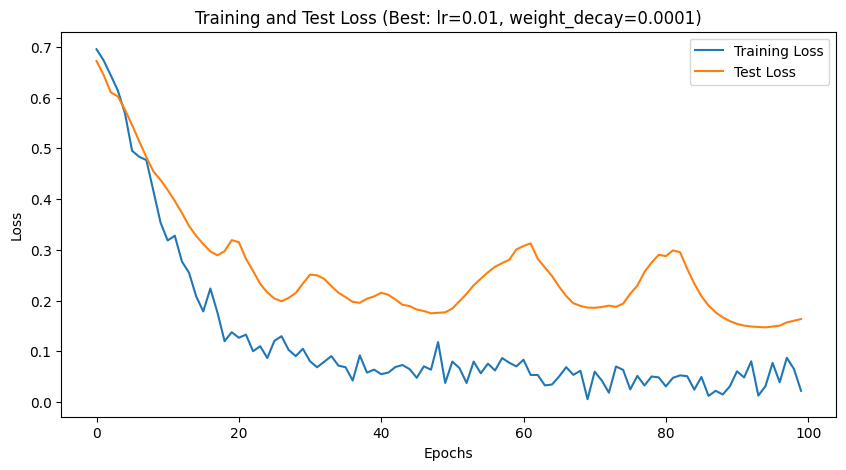

In [ ]:

# Assuming the presence of a class MLP and a data object

learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
weight_decays = [5e-4, 1e-4, 5e-3, 1e-3]

# Hyperparameter tuning loop
best_test_acc = -1
best_combination = {}
results = {}

for lr in learning_rates:
    for wd in weight_decays:
        print(f"\nTraining with lr={lr}, weight_decay={wd}")
        model = MLP(in_dim=1022, hidden_ch=16, classes=2)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)

        loss_values = []
        test_loss_values = []

        for epoch in range(1, 101):
            train_loss = train_MLP(model, optimizer, data, criterion)
            test_loss, test_acc,test_pred,conf_mat = test_MLP(model, data, criterion)

            loss_values.append(train_loss)
            test_loss_values.append(test_loss)

            if epoch % 10 == 0:
              print(f'Epoch: {epoch:03d}, lr={lr}, wd={wd}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        # Store results for comparison
        results[(lr, wd)] = (loss_values, test_loss_values, test_acc)

        # Update the best performing combination
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_combination = {'lr': lr, 'wd': wd, 'loss_values': loss_values, 'test_loss_values': test_loss_values}
            best_test_pred=test_pred
            best_conf_mat=conf_mat

# Plotting for the best combination
lr, wd = best_combination['lr'], best_combination['wd']
print(f"\nBest performing combination: lr={lr}, weight_decay={wd}, Test Acc={best_test_acc:.4f}")
plt.figure(figsize=(10, 5))
plt.plot(best_combination['loss_values'], label='Training Loss')
plt.plot(best_combination['test_loss_values'], label='Test Loss')
plt.title(f"Training and Test Loss (Best: lr={lr}, weight_decay={wd})")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#best_test_acc, best_conf_mat, best_test_pred, test_true = test(model, data, criterion)
print(f'Final Test Accuracy: {best_test_acc:.4f}')
print('Final Confusion Matrix:\n', best_conf_mat)

Final Test Accuracy: 0.9500
Final Confusion Matrix:
 [[ 9  0]
 [ 1 10]]


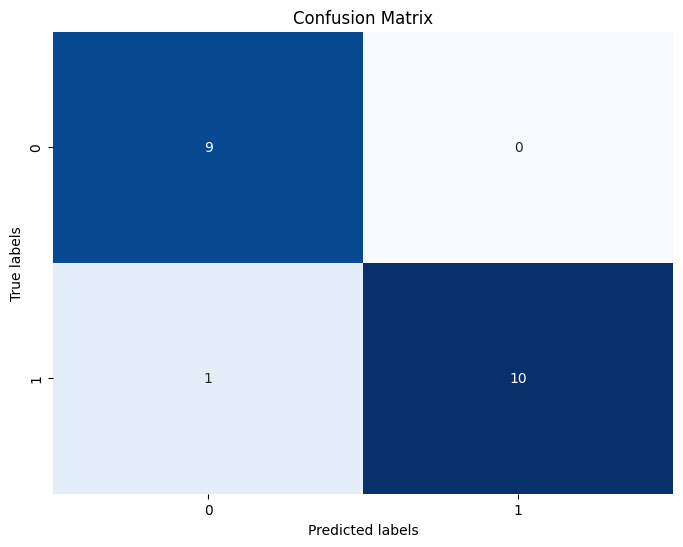

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(best_conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(data.y[data.test_mask].cpu().numpy(), best_test_pred.cpu().numpy(), target_names=['Class 0', 'Class 1'])
print(report)

mcc = matthews_corrcoef(data.y[data.test_mask].cpu().numpy(), best_test_pred.cpu().numpy())
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

              precision    recall  f1-score   support

     Class 0       0.90      1.00      0.95         9
     Class 1       1.00      0.91      0.95        11

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

Matthews Correlation Coefficient: 0.9045


### Now, with GCN



In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_size,hidden_channels,classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(in_size, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(in_size=1022,hidden_channels=16,classes=2)
print(model)

GCN(
  (conv1): GCNConv(1022, 16)
  (conv2): GCNConv(16, 2)
)


In [ ]:
def train_GNN(model, optimizer, data, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def test_GNN(model, data, criterion):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_loss = criterion(out[data.test_mask], data.y[data.test_mask])
    test_pred = pred[data.test_mask]
    test_true = data.y[data.test_mask]
    test_correct = test_pred == test_true
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    conf_mat = confusion_matrix(test_true.cpu().numpy(), test_pred.cpu().numpy())
    return test_loss.item(), test_acc,test_pred,conf_mat

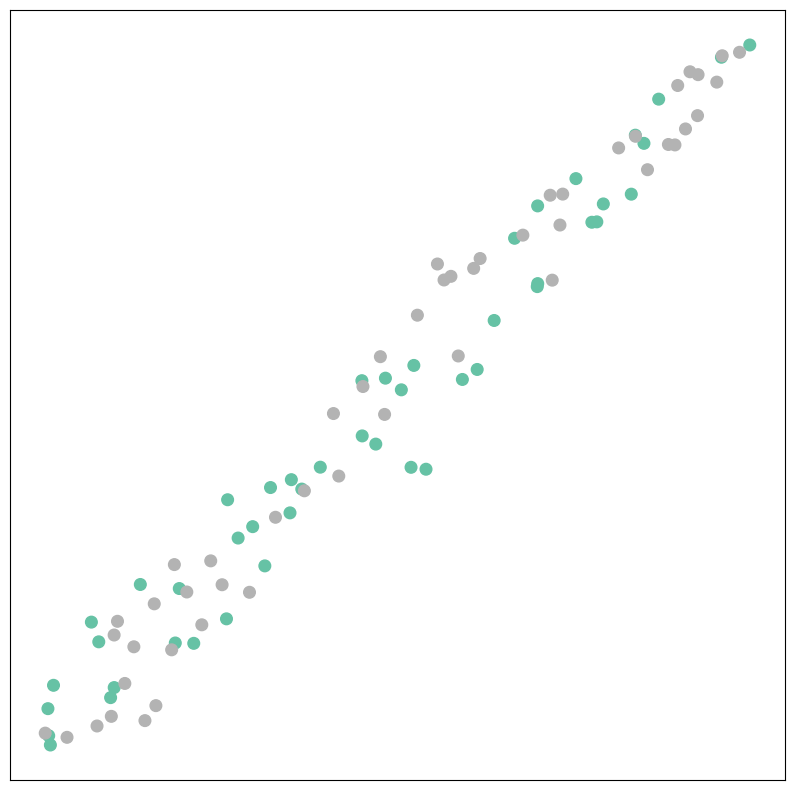

In [ ]:
model = GCN(in_size=1022,hidden_channels=16,classes=2)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

<IPython.core.display.Javascript object>


Training with lr=0.01, weight_decay=0.0005
Epoch: 020, lr=0.01, wd=0.0005, Training Loss: 0.6877, Test Loss: 0.6950, Test Acc: 0.5500
Epoch: 040, lr=0.01, wd=0.0005, Training Loss: 0.6784, Test Loss: 0.6790, Test Acc: 0.6000
Epoch: 060, lr=0.01, wd=0.0005, Training Loss: 0.6780, Test Loss: 0.6715, Test Acc: 0.7500
Epoch: 080, lr=0.01, wd=0.0005, Training Loss: 0.6667, Test Loss: 0.6591, Test Acc: 0.6500
Epoch: 100, lr=0.01, wd=0.0005, Training Loss: 0.6682, Test Loss: 0.6472, Test Acc: 0.6500
Epoch: 120, lr=0.01, wd=0.0005, Training Loss: 0.6297, Test Loss: 0.6435, Test Acc: 0.6500
Epoch: 140, lr=0.01, wd=0.0005, Training Loss: 0.6528, Test Loss: 0.6523, Test Acc: 0.6500
Epoch: 160, lr=0.01, wd=0.0005, Training Loss: 0.6421, Test Loss: 0.6305, Test Acc: 0.7000
Epoch: 180, lr=0.01, wd=0.0005, Training Loss: 0.7195, Test Loss: 0.6257, Test Acc: 0.7500
Epoch: 200, lr=0.01, wd=0.0005, Training Loss: 0.6603, Test Loss: 0.6286, Test Acc: 0.6500
Epoch: 220, lr=0.01, wd=0.0005, Training Loss:

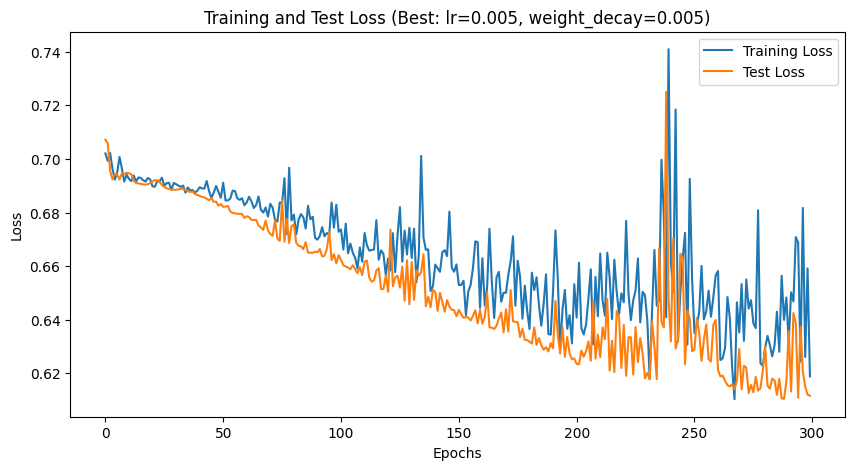

In [ ]:

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Assuming the presence of a class MLP and a data object

learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
weight_decays = [5e-4, 1e-4, 5e-3, 1e-3]

# Hyperparameter tuning loop
best_test_acc = -1
best_combination = {}
results = {}

for lr in learning_rates:
    for wd in weight_decays:
        print(f"\nTraining with lr={lr}, weight_decay={wd}")
        model = GCN(in_size=1022,hidden_channels=16,classes=2)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)

        loss_values = []
        test_loss_values = []

        for epoch in range(1, 301):
            train_loss = train_GNN(model, optimizer, data, criterion)
            test_loss, test_acc,test_pred,conf_mat = test_GNN(model, data, criterion)

            loss_values.append(train_loss)
            test_loss_values.append(test_loss)

            if epoch % 20 == 0:
                print(f'Epoch: {epoch:03d}, lr={lr}, wd={wd}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        # Store results for comparison
        results[(lr, wd)] = (loss_values, test_loss_values, test_acc)

        # Update the best performing combination
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_combination = {'lr': lr, 'wd': wd, 'loss_values': loss_values, 'test_loss_values': test_loss_values}
            best_test_pred=test_pred
            best_conf_mat=conf_mat

# Plotting for the best combination
lr, wd = best_combination['lr'], best_combination['wd']
print(f"\nBest performing combination: lr={lr}, weight_decay={wd}, Test Acc={best_test_acc:.4f}")
plt.figure(figsize=(10, 5))
plt.plot(best_combination['loss_values'], label='Training Loss')
plt.plot(best_combination['test_loss_values'], label='Test Loss')
plt.title(f"Training and Test Loss (Best: lr={lr}, weight_decay={wd})")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(f'Final Test Accuracy: {best_test_acc:.4f}')
print('Final Confusion Matrix:\n', best_conf_mat)

Final Test Accuracy: 0.7500
Final Confusion Matrix:
 [[7 2]
 [3 8]]


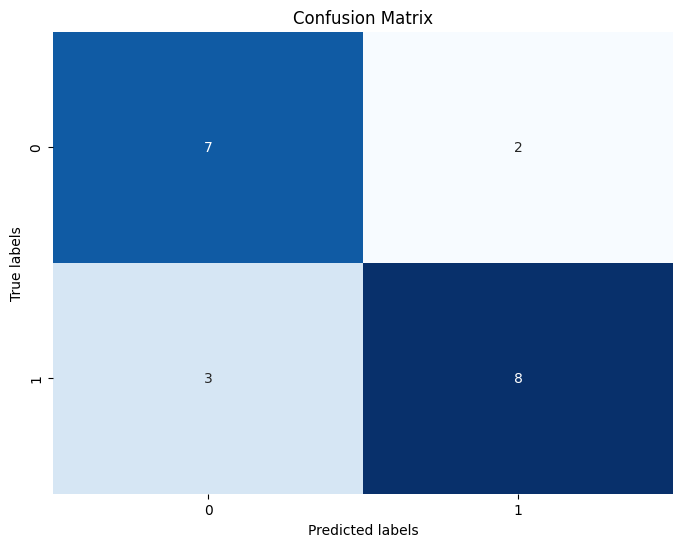

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(best_conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(data.y[data.test_mask].cpu().numpy(), best_test_pred.cpu().numpy(), target_names=['Class 0', 'Class 1'])
print(report)

mcc = matthews_corrcoef(data.y[data.test_mask].cpu().numpy(), best_test_pred.cpu().numpy())
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

              precision    recall  f1-score   support

     Class 0       0.70      0.78      0.74         9
     Class 1       0.80      0.73      0.76        11

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20

Matthews Correlation Coefficient: 0.5025


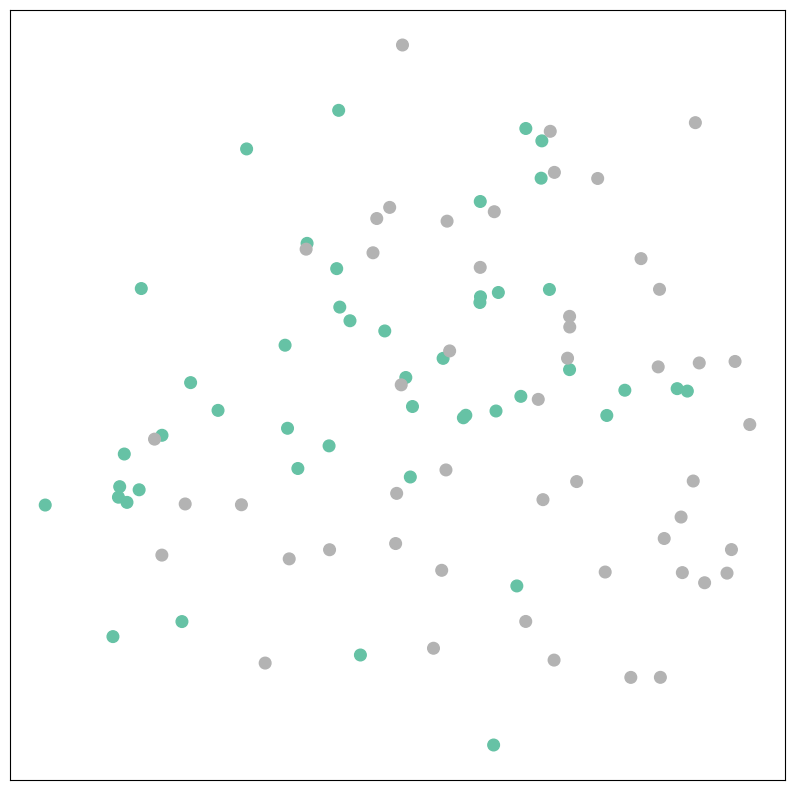

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### Now, with GAT

In [ ]:



class GAT(torch.nn.Module):
    def __init__(self, in_size,hidden_channels,classes,h1,h2):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(in_size, hidden_channels,h1)
        self.conv2 = GATConv(hidden_channels*h1, classes,h2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(in_size=1022,hidden_channels=8,classes=2,h1=8,h2=1)
print(model)

GAT(
  (conv1): GATConv(1022, 8, heads=8)
  (conv2): GATConv(64, 2, heads=1)
)


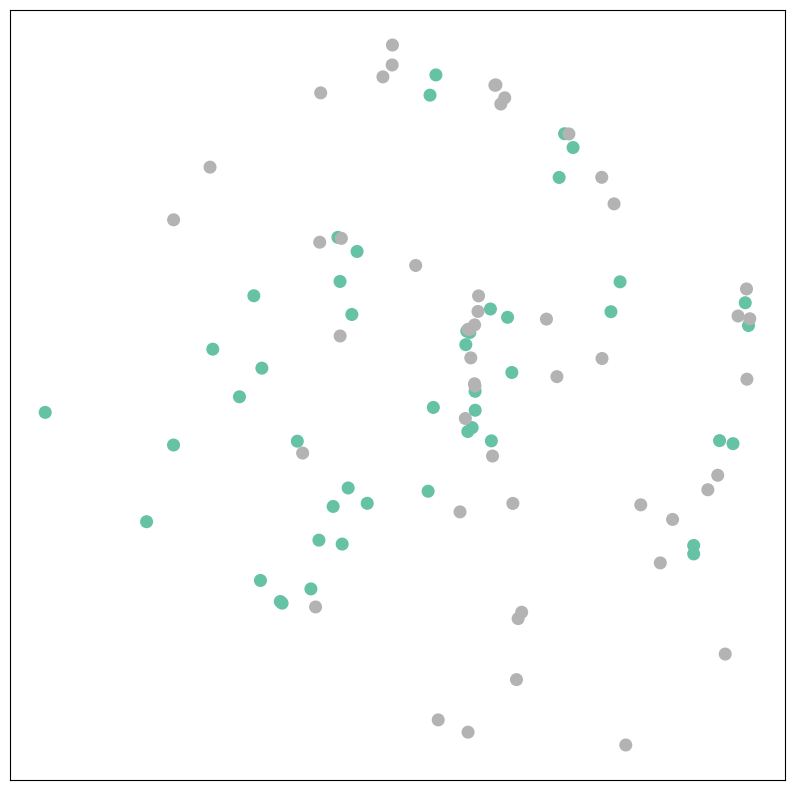

In [ ]:
model = GAT(in_size=1022,hidden_channels=8,classes=2,h1=8,h2=1)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

<IPython.core.display.Javascript object>


Training with lr=0.01, weight_decay=0.0005
Epoch: 050, lr=0.01, wd=0.0005, Training Loss: 0.6668, Test Loss: 0.6310, Test Acc: 0.7500
Epoch: 100, lr=0.01, wd=0.0005, Training Loss: 0.5803, Test Loss: 0.4631, Test Acc: 0.8500
Epoch: 150, lr=0.01, wd=0.0005, Training Loss: 0.5181, Test Loss: 0.4121, Test Acc: 0.8500
Epoch: 200, lr=0.01, wd=0.0005, Training Loss: 0.4587, Test Loss: 0.4141, Test Acc: 0.8500
Epoch: 250, lr=0.01, wd=0.0005, Training Loss: 0.5520, Test Loss: 0.3651, Test Acc: 0.8500
Epoch: 300, lr=0.01, wd=0.0005, Training Loss: 0.4130, Test Loss: 0.3029, Test Acc: 0.9000
Epoch: 350, lr=0.01, wd=0.0005, Training Loss: 0.4264, Test Loss: 0.2941, Test Acc: 0.9000
Epoch: 400, lr=0.01, wd=0.0005, Training Loss: 0.4228, Test Loss: 0.2349, Test Acc: 0.9500
Epoch: 450, lr=0.01, wd=0.0005, Training Loss: 0.4657, Test Loss: 0.2143, Test Acc: 0.9500
Epoch: 500, lr=0.01, wd=0.0005, Training Loss: 0.4100, Test Loss: 0.3494, Test Acc: 0.8500

Training with lr=0.01, weight_decay=0.0001
Ep

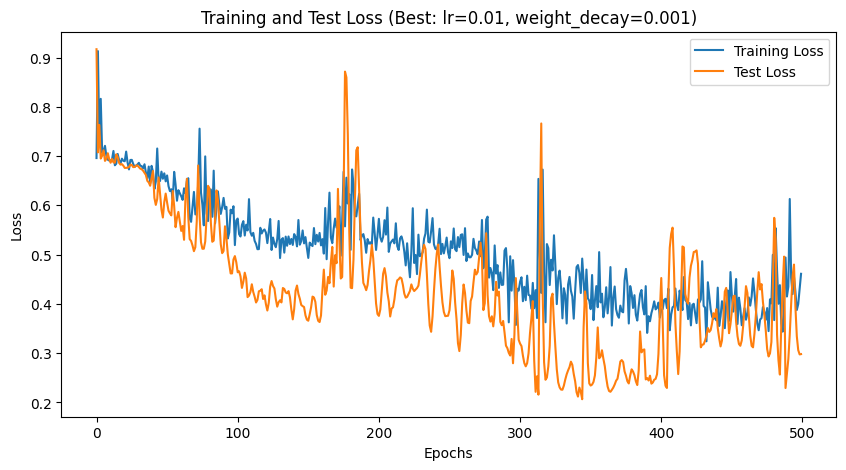

In [ ]:

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Assuming the presence of a class MLP and a data object

learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
weight_decays = [5e-4, 1e-4, 5e-3, 1e-3]

# Hyperparameter tuning loop
best_test_acc = -1
best_combination = {}
results = {}

for lr in learning_rates:
    for wd in weight_decays:
        print(f"\nTraining with lr={lr}, weight_decay={wd}")
        model = GAT(in_size=1022,hidden_channels=8,classes=2,h1=8,h2=1)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)

        loss_values = []
        test_loss_values = []

        for epoch in range(1, 501):
            train_loss = train_GNN(model, optimizer, data, criterion)
            test_loss, test_acc,test_pred,conf_mat = test_GNN(model, data, criterion)

            loss_values.append(train_loss)
            test_loss_values.append(test_loss)

            if epoch % 50 == 0:
                print(f'Epoch: {epoch:03d}, lr={lr}, wd={wd}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        # Store results for comparison
        results[(lr, wd)] = (loss_values, test_loss_values, test_acc)

        # Update the best performing combination
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_combination = {'lr': lr, 'wd': wd, 'loss_values': loss_values, 'test_loss_values': test_loss_values}
            best_test_pred=test_pred
            best_conf_mat=conf_mat

# Plotting for the best combination
lr, wd = best_combination['lr'], best_combination['wd']
print(f"\nBest performing combination: lr={lr}, weight_decay={wd}, Test Acc={best_test_acc:.4f}")
plt.figure(figsize=(10, 5))
plt.plot(best_combination['loss_values'], label='Training Loss')
plt.plot(best_combination['test_loss_values'], label='Test Loss')
plt.title(f"Training and Test Loss (Best: lr={lr}, weight_decay={wd})")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(f'Final Test Accuracy: {best_test_acc:.4f}')
print('Final Confusion Matrix:\n', best_conf_mat)

Final Test Accuracy: 0.9000
Final Confusion Matrix:
 [[ 8  1]
 [ 1 10]]


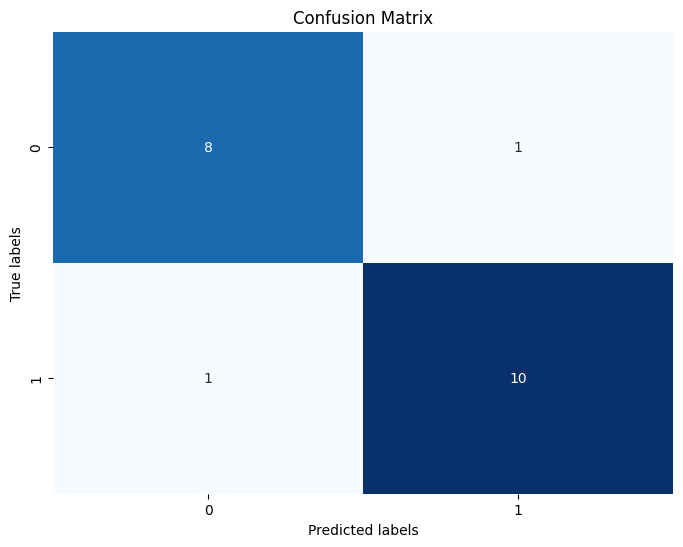

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(best_conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(data.y[data.test_mask].cpu().numpy(), best_test_pred.cpu().numpy(), target_names=['Class 0', 'Class 1'])
print(report)

mcc = matthews_corrcoef(data.y[data.test_mask].cpu().numpy(), best_test_pred.cpu().numpy())
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

              precision    recall  f1-score   support

     Class 0       0.89      0.89      0.89         9
     Class 1       0.91      0.91      0.91        11

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20

Matthews Correlation Coefficient: 0.7980


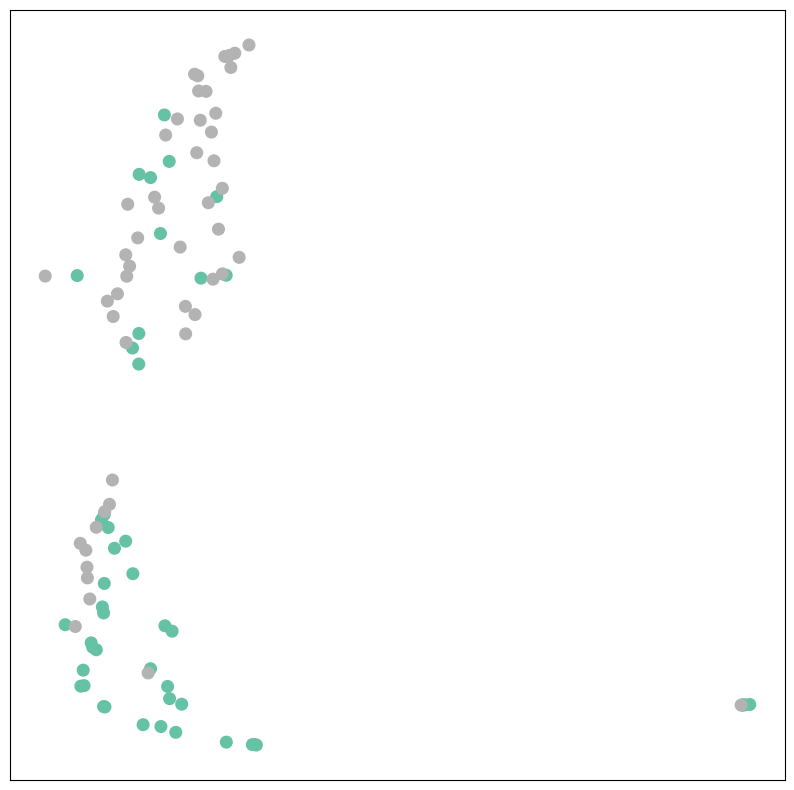

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)